In [ ]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf
from scipy import stats
sns.set()

In [ ]:
class HSIC:

    def __init__(self):
        """
        For regular HSIC, the equation 3 is
        HSIC(D, H, G) = (m-1)^(-2) tr(KxHKyH)

        """
        pass

    # this is exact implementation of HSIC
    # but I found the effect is not good when training the network
    # using the implementation below
    def pairwise_distances(self, x):
        #x should be two dimensional
        instances_norm = torch.sum(x**2,-1).reshape((-1,1))
        return -2*torch.mm(x,x.t()) + instances_norm + instances_norm.t()

    def GaussianKernelMatrix(self, x, sigma=1):
        pairwise_distances_ = self.pairwise_distances(x)
        return torch.exp(-pairwise_distances_ /sigma)

    def hsic_actual(self, x, y, s_x=1, s_y=1):
        m, _ = x.shape #batch size
        K = self.GaussianKernelMatrix(x,s_x)
        L = self.GaussianKernelMatrix(y,s_y)
        H = torch.eye(m) - 1.0/m * torch.ones((m,m))
        H = H.double()
        hsic = torch.trace(torch.mm(L,torch.mm(H,torch.mm(K,H))))/((m-1)**2)
        return hsic

    # this is the implement for the actual utilization on training the model
    def distance_matrix(self, X):
        """
        This is part of Kx in the equation 3
        it just computes the |x - y|^2 in the kernel matrix
        thus it is called distance matrix
        """

        # X*X is the element-wise product
        # summing the result along the axis=1,
        # then the change the shape of tensor in [n, 1] form
        # print("X time X :", X*X)
        r = torch.sum(X*X, 1).view([-1, 1])

        # calculate the auto-convariance of X by X @ X^T
        a = torch.mm(X, torch.transpose(X,0,1))

        # calculate the distance between x_i and x_j and
        # combine all the values in the form of matrix
        D = r.expand_as(a) - 2*a +  torch.transpose(r,0,1).expand_as(a)

        # just make sure the distance is positive one
        D = torch.abs(D)

        return D


    def kernel_matrix(self, X, sigma):

        """
        It utilizes the result from distance matrix ||x - y||^2
        and the supplied sigma (sometimes, the sigma could be estimated from the data)
        to calculate the centered kernel matrix by multiplying kernel matrix
        such as k(x,y) ~ exp(-1/2 ||x - y||^2 / sigma^2 * dimensions) with the centering matrix H = I_m - 1/m 1m 1m^T

        In the equation HSIC (D, H, G) = (m-1)^{-2} tr(KxHKyH), it is KxH or KyH
        """

        # take out the number and the dimension of the data points
        size, dimension = X.shape

        # size = int(X.size()[0])
        # dimension = int(X.size()[1])
        # this is the centering matrix H
        H = torch.eye(size) - (1./size) * torch.ones([size,size])

        # this is the distance matrix for X
        Dxx = self.distance_matrix(X)

        # this is the variance scaled by dimension
        variance = 2.*sigma*sigma*dimension

        # this is the kernel matrices
        Kx = torch.exp( -Dxx / variance).type(torch.FloatTensor)

        # this is the centered kernel matrices
        Kxc = torch.mm(Kx,H)

        return Kxc



    def hsic_regular(self, X, Y, sigma):

        """
        This is the calculation of equation 3
        HSIC (D, H, G) = (m-1)^{-2} tr(KxH \bar{KyH})
        \bar indicates conjugate
        """

        Kxc = self.kernel_matrix(X, sigma)
        Kyc = self.kernel_matrix(Y, sigma)
        #print(Kyc.t())
        #print(Kxc)
        Ktr = torch.mul(Kxc, Kyc.t())
        #print("KtK", Ktr)
        regular_hsic = torch.mean(Ktr)

        # this is the trace of the convariance matrix
        # row, col = Ktr.shape
        # regular_hsic = torch.trace(Ktr)/((row-1)*(col-1))

        return regular_hsic


    def hsic_normalized(self, X, Y, sigma):
        """
        """
        Pxy = self.hsic_regular(X, Y, sigma)
        Px = torch.sqrt(self.hsic_regular(X, X, sigma))
        Py = torch.sqrt(self.hsic_regular(Y, Y, sigma))
        normalized_hsic = Pxy/(Px*Py)

        return normalized_hsic


In [ ]:
# prepare the training data
broadcast_side_2021 = pd.read_csv("./sourcedata/2022_broadcast_side.csv")
broadcast_side_2021.drop('Unnamed: 0', axis=1, inplace=True)
#broadcast_side_2021.drop('DOY', axis=1, inplace=True)
broadcast_side_2021 = broadcast_side_2021[['DOY', 'TA', 'FH2O', 'H2O','FN2O']]
print(broadcast_side_2021)

# smooth the data to avoid the effect of white noise
# smooth_data = broadcast_side_2021.ewm(span=5).mean()
# we do not do the smoothing operation on the original data
# since it actually did not have any positive effect on
# time series analysis
# scale the data in the range of (0.05, 0.95)
scaler_broadcast_side_2021 = MinMaxScaler((0.05, 0.95))
scaled_broadcast_side_2021 = scaler_broadcast_side_2021.fit_transform(broadcast_side_2021)
print(scaled_broadcast_side_2021)

          DOY     TA      FH2O      H2O       FN2O
500   220.317  15.85  0.002654  18.2060   89.92710
501   220.338  16.03  0.002654  18.3108   77.54900
502   220.359  16.10  0.005648  18.5359   68.31830
503   220.380  16.11  0.007354  18.4365  105.42500
504   220.401  15.95  0.014389  18.3378  139.43100
...       ...    ...       ...      ...        ...
4495  303.505  13.56  0.029229  12.6235    1.42327
4496  303.526  14.09  0.029327  13.6491    1.42927
4497  303.547  15.17  0.023904  13.9837    1.47802
4498  303.567  16.37  0.019987  14.3749    1.49600
4499  303.588  15.98  0.045541  14.1656    1.45363

[4000 rows x 5 columns]
[[0.05       0.49987887 0.05208643 0.38101312 0.17891968]
 [0.05022726 0.49382234 0.05152196 0.36909651 0.1905993 ]
 [0.05045452 0.50569314 0.05149604 0.36157526 0.17932325]
 ...
 [0.94954548 0.14981157 0.05566298 0.1220868  0.05149158]
 [0.94977274 0.14472409 0.05556089 0.11871169 0.05147147]
 [0.95       0.13430686 0.05642998 0.11318114 0.05153185]]


In [ ]:
org_data = pd.DataFrame(scaled_broadcast_side_2021, columns=['DOY','Temperature', 'Precipitation', 'Moisture', 'FN2O'])

In [ ]:
broadcast_side_2021.describe()

,DOY,TA,FH2O,H2O,FN2O
count,4684.000000,4684.000000,4684.000000,4684.000000,4684.000000
mean,258.656325,14.787370,0.144328,15.535037,34.185712
std,28.148034,7.719376,0.286859,6.334547,49.519731
min,210.007000,0.000000,0.000135,3.929720,0.095396
25%,234.247750,9.420000,0.007300,10.664000,2.016237
50%,258.640500,14.585000,0.025404,14.920050,7.291640
75%,283.031250,19.670000,0.142346,19.502400,52.573325
max,307.422000,37.200000,3.447980,45.635200,255.440000


In [ ]:
# now we need to find the distribution of first order difference
diff_dist_2021 = pd.DataFrame(scaled_broadcast_side_2021, \
                         columns=['DOY','Temperature', 'Precipitation', 'Moisture', 'FN2O']).diff().dropna()
# drop day of the year, since it is the time stamp and play a role of time filter in this algorithm
diff_dist_2021.drop('DOY', axis=1, inplace=True)

In [ ]:
print(diff_dist_2021)

      Temperature  Precipitation  Moisture          FN2O
1        0.033324       0.107255  0.011090  1.699211e-03
2        0.021798       0.093359  0.014228  1.557357e-03
3        0.041091       0.139902  0.009339  7.333791e-03
4       -0.021548      -0.120187  0.035996  5.281187e-03
5        0.004761      -0.041000 -0.008338 -3.242760e-03
...           ...            ...       ...           ...
3995    -0.028062       0.000000  0.032932  0.000000e+00
3996    -0.012778       0.000000 -0.029201  0.000000e+00
3997    -0.009772       0.000145 -0.004082  0.000000e+00
3998    -0.032572       0.204066 -0.047546  0.000000e+00
3999    -0.024053      -0.203871 -0.011518 -8.122043e-07

[3999 rows x 4 columns]


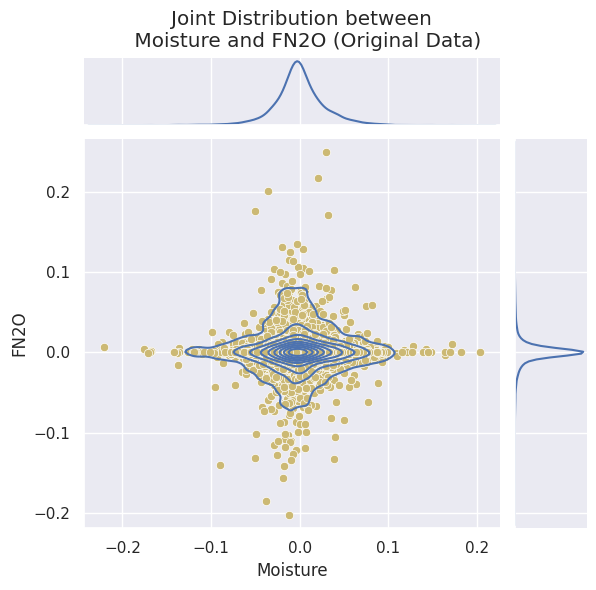

In [ ]:
g = sns.jointplot(diff_dist_2021, x='Moisture', y='FN2O', kind='kde')
g.plot_joint(sns.scatterplot, color="y")
g.fig.suptitle("Joint Distribution between \n Moisture and FN2O (Original Data)")
g.fig.subplots_adjust(top=0.90)

In [ ]:
def discretization(samplers, nbins):
    freq, bin_edges = np.histogramdd(samplers, nbins)
    n = len(samplers)
    freq_rate = freq / n
    x_bin_w = bin_edges[0][1] - bin_edges[0][0]
    y_bin_w = bin_edges[1][1] - bin_edges[1][0]
    z_bin_w = bin_edges[2][1] - bin_edges[2][0]
    t_bin_w = bin_edges[3][1] - bin_edges[3][0]

    return freq_rate, bin_edges, x_bin_w, y_bin_w, z_bin_w, t_bin_w

In [ ]:
def get_joint_prob_4d(freq_rate, bin_edges, x_bin_w, y_bin_w, z_bin_w, t_bin_w, \
                      vector):
    # calculate the index along the x and y axis
    x_res = vector[0] - bin_edges[0][0]
    ix = int(x_res/x_bin_w)

    y_res = vector[1] - bin_edges[1][0]
    iy = int(y_res/y_bin_w)

    z_res = vector[2] - bin_edges[2][0]
    iz = int(z_res/z_bin_w)

    t_res = vector[3] - bin_edges[3][0]
    it = int(t_res/t_bin_w)

    if ix < 0 or ix > len(freq_rate) - 1 or iy < 0 or iy > len(freq_rate) - 1 or \
       iz < 0 or iz > len(freq_rate) - 1 or it < 0 or it > len(freq_rate) - 1:
    # return a small value, since it is discrete system and our distribution may not be sufficient
        return 1e-10
    else:
        return freq_rate[ix][iy][iz][it]

In [ ]:
def metropolis_hastings_4d(spare_data, real_data, diff_all, beta, bins=15):
    x_old = np.array([0, 0, 0, 0])
    index_x = 0
    index_y = 0
    time_series = []
    gen_lst = [0]
    freq_rate, bin_edges, x_bin_w, y_bin_w, z_bin_w, t_bin_w = \
                    discretization(np.array(diff_all), nbins=bins)
    search_index = [0]

    for ix in range(len(real_data)):
        ix = gen_lst[-1]

        for iy in range(search_index[-1], len(spare_data)):

            # this condition could be relaxed and use the real data as the reference all the time

            if len(time_series) != 0:
                x_new = (1 - beta)*np.array(spare_data[iy][1:5] - time_series[-1][1:5]) + beta*np.array(spare_data[iy][1:5] - real_data[ix][1:5])
            else:
                x_new = np.array(spare_data[iy][1:5] - real_data[ix][1:5])

            #x_new = np.array(spare_data[iy][1:5] - real_data[ix][1:5])
            # this is to compare the time in a small area
            # this data is very sentive to the time stamp
            time_dist = spare_data[iy][0] - real_data[ix][0]

            if time_dist < 0.006 and time_dist > -0.006:

                alpha = np.min([get_joint_prob_4d(freq_rate, bin_edges, x_bin_w, y_bin_w, \
                                                z_bin_w, t_bin_w, x_new) \
                                /(get_joint_prob_4d(freq_rate, bin_edges, x_bin_w, y_bin_w, \
                                                z_bin_w, t_bin_w, x_old)), 1])

                if np.random.rand() < alpha:

                    x_old = x_new
                    time_series.append(spare_data[iy])
                    print("Alpha :", alpha)
                    print("Add into the time series : ", spare_data[iy])
                    print("Index X : ", ix)
                    print("gen_lst : ", gen_lst[-1])
                    print("Search Index : ", search_index[-1])
                    index_x = ix + 1
                    gen_lst.append(index_x)
                    index_y = iy + 1
                    search_index.append(index_y)
                    break

    return time_series, gen_lst

In [ ]:
dist_prob = diff_dist_2021
dist_prob.shape

(3999, 4)

In [ ]:
spare_data = np.load('aug_broadcast_middle_2022.npy')
len(spare_data)

1924000

In [ ]:
spare_data = torch.load('gen_2021_broadcast_nitrogen_b2.pth', map_location=torch.device('cpu'))
spare_data

tensor([[1.1952e-02, 9.9293e-01, 2.8108e-01, 1.9725e-01, 7.9783e-02, 3.4582e-01],
        [1.2158e-02, 9.9418e-01, 2.1322e-01, 1.8518e-01, 5.2666e-02, 2.7795e-01],
        [1.2624e-02, 9.9525e-01, 2.3533e-01, 1.4156e-01, 9.2976e-02, 4.1656e-01],
        ...,
        [9.9728e-01, 4.5565e-02, 1.1391e-01, 2.6347e-03, 1.4756e-01, 1.2740e-03],
        [9.9730e-01, 4.0191e-02, 1.6964e-01, 6.5506e-03, 8.0245e-02, 6.1196e-04],
        [9.9744e-01, 6.0476e-02, 1.2110e-01, 5.4121e-03, 1.1244e-01, 6.9954e-04]],
       requires_grad=True)

In [ ]:
spare_data_1 = spare_data[:,[0,2,3,4,5]]

In [ ]:
spare_data = spare_data.detach().numpy()
spare_data

array([[1.19522316e-02, 9.92928326e-01, 2.81084567e-01, 1.97252572e-01,
        7.97829628e-02, 3.45822960e-01],
       [1.21583277e-02, 9.94178414e-01, 2.13215426e-01, 1.85179487e-01,
        5.26657738e-02, 2.77947515e-01],
       [1.26243550e-02, 9.95251656e-01, 2.35334724e-01, 1.41561329e-01,
        9.29761380e-02, 4.16560382e-01],
       ...,
       [9.97278392e-01, 4.55646925e-02, 1.13914043e-01, 2.63472064e-03,
        1.47564635e-01, 1.27404102e-03],
       [9.97301280e-01, 4.01913039e-02, 1.69641227e-01, 6.55056909e-03,
        8.02454650e-02, 6.11957686e-04],
       [9.97440100e-01, 6.04762807e-02, 1.21096939e-01, 5.41206961e-03,
        1.12443775e-01, 6.99538505e-04]], dtype=float32)

In [ ]:
spare_data = spare_data[spare_data[:,0].argsort()]
len(spare_data)

1920000

In [ ]:
print(spare_data_old)

[[0.02455521 0.44109404 0.07181142 0.35678393 0.08878747]
 [0.02477502 0.37897894 0.06816772 0.29722357 0.07466388]
 [0.02480562 0.40663472 0.08725864 0.15781754 0.07995421]
 ...
 [0.95738518 0.44827846 0.0827941  0.28380546 0.03754591]
 [0.95748323 0.50903052 0.08103512 0.29312533 0.03825387]
 [0.95766717 0.49546903 0.06575879 0.32182226 0.03779434]]


In [ ]:
time_series, gen_lst = metropolis_hastings_4d(spare_data_old, scaled_broadcast_side_2021, dist_prob, beta = 0.04, bins = 15)

In [ ]:
fake_data = pd.DataFrame(time_series, columns=['DOY','Temperature', 'Precipitation', 'Moisture', 'FN2O'])

In [ ]:
fake_data

,DOY,Temperature,Precipitation,Moisture,FN2O
0,0.050000,0.338391,0.192183,0.202774,0.108360
1,0.044227,0.139701,0.104411,0.056571,0.248703
2,0.044449,0.401832,0.067738,0.304530,0.476155
3,0.044673,0.123970,0.023182,0.198570,0.619296
4,0.044898,0.346943,0.142954,0.216403,0.452057
...,...,...,...,...,...
3995,0.943113,0.212189,0.053230,0.172228,0.003582
3996,0.943348,0.190737,0.047016,0.205055,0.004898
3997,0.943547,0.188623,0.059385,0.234829,0.010947
3998,0.943828,0.185708,0.110673,0.215324,0.007619


In [ ]:
smooth_data = fake_data.ewm(alpha=0.2).mean()
smooth_data

,DOY,Temperature,Precipitation,Moisture,FN2O
0,0.050000,0.338391,0.192183,0.202774,0.108360
1,0.046793,0.228007,0.143421,0.121550,0.186328
2,0.045832,0.299247,0.112403,0.196542,0.305110
3,0.045440,0.239871,0.082179,0.197229,0.411542
4,0.045279,0.271723,0.100258,0.202933,0.423594
...,...,...,...,...,...
3995,0.942211,0.268185,0.083412,0.214753,0.006652
3996,0.942439,0.252696,0.076133,0.212813,0.006301
3997,0.942660,0.239881,0.072784,0.217216,0.007231
3998,0.942894,0.229047,0.080361,0.216838,0.007308


In [ ]:
hsic = HSIC()

In [ ]:
hsic_1 = hsic.hsic_normalized(torch.tensor(scaled_broadcast_side_2021), torch.tensor(smooth_data.values), 1)
print(hsic_1)

tensor(0.8694)


In [ ]:
np.save('fake_broadcast_side_2021_9640_b100.npy', fake_data)

In [ ]:
stats.kstest(diff_all_1['Moisture'], diff_all_2['Moisture'])

KstestResult(statistic=0.01900475118779695, pvalue=0.4656530792582479, statistic_location=-0.0047495799985735054, statistic_sign=-1)

In [ ]:
dist_prob

,Temperature,Precipitation,Moisture,FN2O
1,0.033324,0.107255,0.011090,1.699211e-03
2,0.021798,0.093359,0.014228,1.557357e-03
3,0.041091,0.139902,0.009339,7.333791e-03
4,-0.021548,-0.120187,0.035996,5.281187e-03
5,0.004761,-0.041000,-0.008338,-3.242760e-03
...,...,...,...,...
3995,-0.028062,0.000000,0.032932,0.000000e+00
3996,-0.012778,0.000000,-0.029201,0.000000e+00
3997,-0.009772,0.000145,-0.004082,0.000000e+00
3998,-0.032572,0.204066,-0.047546,0.000000e+00


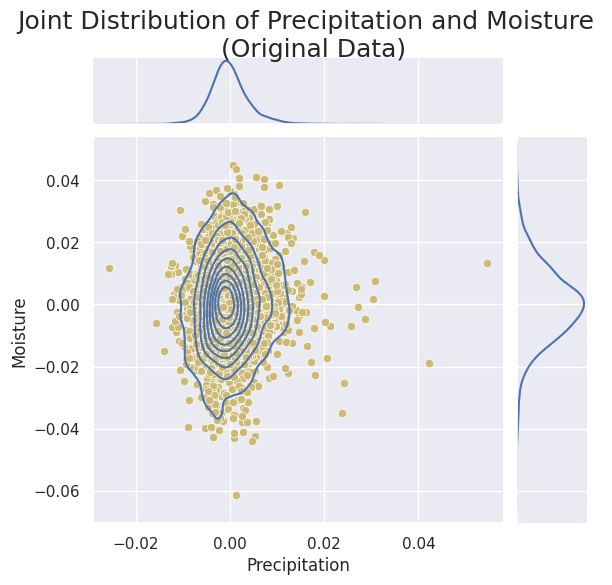

In [ ]:
plt.rcParams.update({'font.size': 15})
g = sns.jointplot(diff_all, x='Precipitation', y='Moisture', kind='kde')
g.plot_joint(sns.scatterplot, color="y")
g.fig.suptitle("Joint Distribution of Precipitation and Moisture \n (Original Data)")
g.fig.subplots_adjust(top=0.90)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


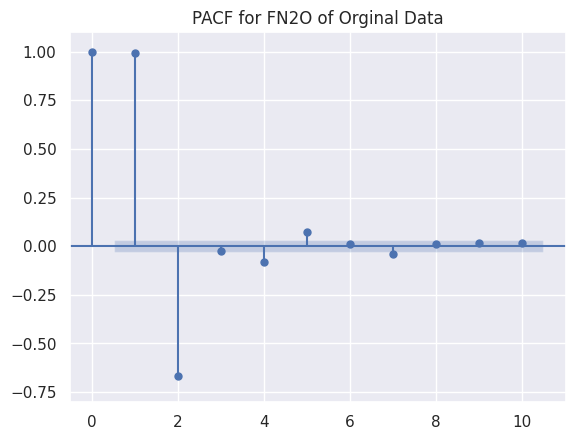

In [ ]:
plot_pacf(smooth_data['Moisture'], lags=10)
plt.ylim(-0.80, 1.1)
plt.title('PACF for FN2O of Orginal Data')
plt.show()

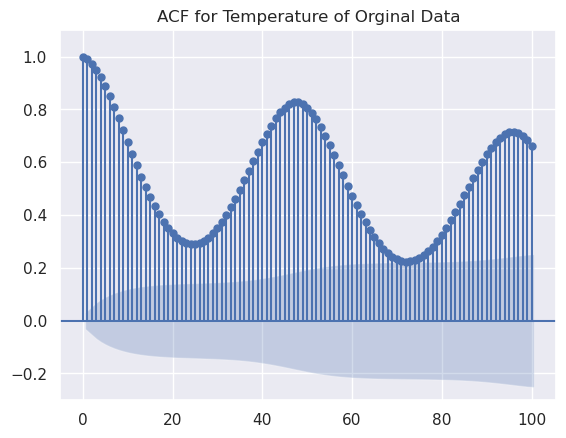

In [ ]:
plot_acf(org_data['Temperature'], lags=100)
plt.ylim(-0.3, 1.1)
plt.title('ACF for Temperature of Orginal Data')
plt.show()

In [ ]:
real_data = pd.DataFrame(scaled_broadcast_side_2021)

In [ ]:
hsic = HSIC()

In [ ]:
hsic_1 = hsic.hsic_normalized(torch.tensor(scaled_broadcast_side_2021), torch.tensor(smooth_data.values), 1)
print(hsic_1)

tensor(0.8013)
